## Prediction model w/ PCA
The data were transformed with principal components analysis (PCA).

In [7]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
#for performance plots
import matplotlib.pyplot as plt

In [8]:
train_set = np.array(pd.read_csv('data/train_set.csv'))
test_set = np.array(pd.read_csv('data/test_set.csv'))

nFeat = len(train_set[0,:]) - 2

X_train = train_set[:,:nFeat]
Y_train = train_set[:,nFeat:nFeat+2]
X_test = test_set[:,:nFeat]
Y_test = test_set[:, nFeat:nFeat+2]

In [9]:
## reducing data by using PCA
from sklearn.decomposition import PCA

n_component=4
pca = PCA(n_components=n_component)
X_train = pca.fit_transform(X_train)
X_train = pd.DataFrame(data=X_train, columns = range(n_component))

[0.59221867 0.17085697 0.11908362 0.10357789]


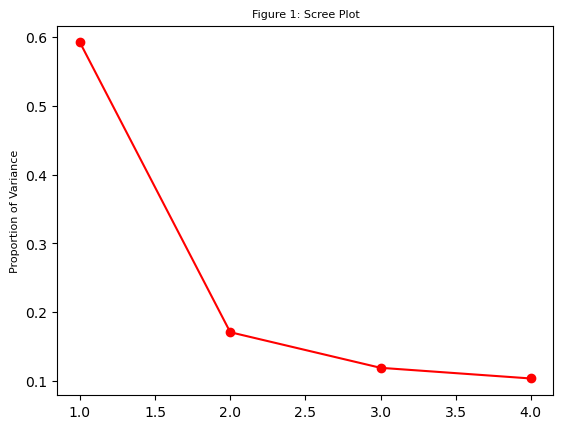

In [10]:
## confirmation of component's variance
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

PC_numbers = np.arange(pca.n_components_) + 1

print(prop_var)

plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

In [11]:
X_test = pca.transform(X_test)
X_test = pd.DataFrame(data=X_test, columns = range(n_component))

In [12]:
X_train = X_train.values[:,:]
X_test = X_test.values[:,:]

In [13]:
# scale the train and test set
scalerx = RobustScaler().fit (X_train)
X_train = scalerx.transform(X_train)
X_test  = scalerx.transform(X_test)

In [6]:
## developing feed-forward neural network
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import torch.nn.functional as F

## construction of hidden layers
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_component,256)
        self.fc2 = nn.Linear(256, 512)
        self.dp1 = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 2)
        
    def forward(self, x):
        h = F.selu(self.fc1(x))
        h = F.selu(self.fc2(h))
        h = self.dp1(h)
        h = F.selu(self.fc3(h))
        h = F.selu(self.fc4(h))
        out = self.fc5(h)
        return out
    ## FNN model training    
    def fit(self, data_loader, criterion, optimizer):
        self.train()
        sum_train_losses = 0

        for data, target in data_loader:
            
            optimizer.zero_grad()
            pred = self(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            sum_train_losses += loss.item()

        return sum_train_losses / len(data_loader)
    ## FNN model evaluation
    def predict(self, data_loader):
        self.eval()
        list_preds = list()

        with torch.no_grad():
            for data, _ in data_loader:
                pred = self(data)
                list_preds.append(pred)

        return torch.cat(list_preds, dim=0).cpu().numpy()

## define loss function    
def RMSELoss(pred,target):
    return torch.sqrt(torch.mean((pred-target)**2))
    

In [15]:
## developing ML models
models = {}
models['KR rbf'] =GridSearchCV(KernelRidge(kernel='rbf'), cv=5, 
                               param_grid={'alpha': [10, 1, 0.1, 1e-2, 1e-3], 'gamma': [0.001, 0.01, 0.1, 1, 10]},
                              scoring ='r2')
models['SVM rbf'] = GridSearchCV(SVR(kernel='rbf'), cv=5, 
                                 param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 0.5, 1, 2]}, 
                                 scoring ='r2')
models['RF'] = GridSearchCV(RandomForestRegressor(),cv=5, #
                                 param_grid ={'max_depth': [5,10,15], 'n_estimators': [20,40,80,120]}, 
                                 scoring='r2')
models['XGBoost'] = GridSearchCV(xgb.XGBRegressor(), cv=5,
                                  param_grid ={'max_depth': [2,5,10,15], 'n_estimators': [20,40,80,120]},
                                  scoring='r2')
models['FNN'] = FNN()


for idx, model in enumerate(models):
    print('model: ', model)
    ## for FNN model, input data converts into torch datatype
    if model == 'FNN':
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.22, shuffle=True, random_state=42)
        
        X_train_t = torch.Tensor(X_train)
        X_val_t = torch.Tensor(X_val)
        X_test_t = torch.Tensor(X_test)
        Y_train_t = torch.Tensor(Y_train)
        Y_val_t = torch.Tensor(Y_val)
        Y_test_t = torch.Tensor(Y_test)

        data_train = TensorDataset(X_train_t, Y_train_t)
        data_val = TensorDataset(X_val_t, Y_val_t)
        data_test = TensorDataset(X_test_t, Y_test_t)
        train_loader = DataLoader(data_train, batch_size=64, shuffle=False)
        val_loader = DataLoader(data_val, batch_size=64, shuffle=False)
        test_loader = DataLoader(data_test, batch_size=64, shuffle=False)

        criterion = RMSELoss
        optimizer = optim.Adam(models[model].parameters())

        for epoch in range(1000):
            models[model].train()
            train_loss = models[model].fit(train_loader, criterion, optimizer)
            models[model].eval()
            val_loss = models[model].fit(val_loader, criterion, optimizer)
           
        Y_pred = models[model].predict(test_loader)
        Y_test_t = Y_test_t.detach().numpy()
        
        r2_yield1 = r2_score(Y_test_t[:,0], Y_pred[:,0])
        r2_yield2 = r2_score(Y_test_t[:,1], Y_pred[:,1])
        mae1 = np.mean(np.abs(Y_pred[:,0]-Y_test_t[:,0]))
        mae2 = np.mean(np.abs(Y_pred[:,1]-Y_test_t[:,1]))
        print('R2 score:     {:.2}\t\t{:.2}'.format(r2_yield1, r2_yield2))
        print('MAE:\t     {:.2}\t\t{:.2}'.format(mae1, mae2))
    
    ## for other models
    else:
        models[model].fit(X_train, Y_train[:,0])
        Y_pred1 = models[model].predict (X_test)
        r2_yield1 = np.around(r2_score(Y_test[:,0], Y_pred1), 2)
        mae1 = np.around(np.mean(np.abs(Y_pred1 - Y_test[:,0])),1)
        models[model].fit(X_train, Y_train[:,1])
        Y_pred2 = models[model].predict (X_test)
        r2_yield2 = np.around(r2_score(Y_test[:,1], Y_pred2), 2)
        mae2 = np.around(np.mean(np.abs(Y_pred2 - Y_test[:,1])),1)
        print('R2 score:     {}\t\t{}'.format(r2_yield1, r2_yield2))
        print('MAE:\t     {}\t\t{}'.format(mae1, mae2))


model:  KR rbf
R2 score:     0.51		0.62
MAE:	     8.2		7.5
model:  SVM rbf
R2 score:     0.36		0.58
MAE:	     9.8		7.9
model:  RF
R2 score:     0.4		0.67
MAE:	     8.6		7.1
model:  XGBoost
R2 score:     0.22		0.66
MAE:	     10.3		7.2
model:  FNN
R2 score:     0.82		0.86
MAE:	     5.9		4.7


## Prediction model w/o PCA

In [1]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
#for performance plots
import matplotlib.pyplot as plt

In [2]:
## omitting the Sterimol values
train_set = np.array(pd.read_csv('data/train_set.csv'))
train_set = np.delete(train_set, [
                                 2,3,4,5,6,7
                                 ], 1)
test_set = np.array(pd.read_csv('data/test_set.csv'))
test_set = np.delete(test_set, [
                               2,3,4,5,6,7
                               ], 1)
nFeat = len(train_set[0,:]) - 2

X_train = train_set[:,:nFeat]
Y_train = train_set[:,nFeat:nFeat+2]
X_test = test_set[:,:nFeat]
Y_test = test_set[:, nFeat:nFeat+2]

In [3]:
# scale the train and test set (if data sets contain the Sterimol values, do not scale the data)
scalerx = StandardScaler().fit (X_train)
X_train = scalerx.transform(X_train)
X_test  = scalerx.transform(X_test)

In [4]:
## developing feed-forward neural network
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import torch.nn.functional as F

## construction of hidden layers
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(nFeat,256)
        self.fc2 = nn.Linear(256, 512)
        self.dp1 = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 2)
        
    def forward(self, x):
        h = F.selu(self.fc1(x))
        h = F.selu(self.fc2(h))
        h = self.dp1(h)
        h = F.selu(self.fc3(h))
        h = F.selu(self.fc4(h))
        out = self.fc5(h)
        return out
    ## FNN model training    
    def fit(self, data_loader, criterion, optimizer):
        self.train()
        sum_train_losses = 0

        for data, target in data_loader:
            
            optimizer.zero_grad()
            pred = self(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            sum_train_losses += loss.item()

        return sum_train_losses / len(data_loader)
    ## FNN model evaluation
    def predict(self, data_loader):
        self.eval()
        list_preds = list()

        with torch.no_grad():
            for data, _ in data_loader:
                pred = self(data)
                list_preds.append(pred)

        return torch.cat(list_preds, dim=0).cpu().numpy()

## define loss function    
def RMSELoss(pred,target):
    return torch.sqrt(torch.mean((pred-target)**2))
    

In [5]:
## developing ML models
models = {}
models['KR rbf'] =GridSearchCV(KernelRidge(kernel='rbf'), cv=5, 
                               param_grid={'alpha': [10, 1, 0.1, 1e-2, 1e-3], 'gamma': [0.001, 0.01, 0.1, 1, 10]},
                              scoring ='r2')
models['SVM rbf'] = GridSearchCV(SVR(kernel='rbf'), cv=5, 
                                 param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 0.5, 1, 2]}, 
                                 scoring ='r2')
models['RF'] = GridSearchCV(RandomForestRegressor(),cv=5, #
                                 param_grid ={'max_depth': [5,10,15], 'n_estimators': [20,40,80,120]}, 
                                 scoring='r2')
models['XGBoost'] = GridSearchCV(xgb.XGBRegressor(), cv=5,
                                  param_grid ={'max_depth': [2,5,10,15], 'n_estimators': [20,40,80,120]},
                                  scoring='r2')
models['FNN'] = FNN()

for idx, model in enumerate(models):
    print('model: ', model)
    
    ## for FNN model, input data converts into torch datatype
    if model == 'FNN':
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.22, shuffle=True, random_state=42)
        
        X_train_t = torch.Tensor(X_train)
        X_val_t = torch.Tensor(X_val)
        X_test_t = torch.Tensor(X_test)
        Y_train_t = torch.Tensor(Y_train)
        Y_val_t = torch.Tensor(Y_val)
        Y_test_t = torch.Tensor(Y_test)

        data_train = TensorDataset(X_train_t, Y_train_t)
        data_val = TensorDataset(X_val_t, Y_val_t)
        data_test = TensorDataset(X_test_t, Y_test_t)
        train_loader = DataLoader(data_train, batch_size=64, shuffle=False)
        val_loader = DataLoader(data_val, batch_size=64, shuffle=False)
        test_loader = DataLoader(data_test, batch_size=64, shuffle=False)

        criterion = RMSELoss
        optimizer = optim.Adam(models[model].parameters())

        for epoch in range(1000):
            models[model].train()
            train_loss = models[model].fit(train_loader, criterion, optimizer)
            models[model].eval()
            val_loss = models[model].fit(val_loader, criterion, optimizer)
           
        Y_pred = models[model].predict(test_loader)
        Y_test_t = Y_test_t.detach().numpy()
        
        r2_yield1 = np.around(r2_score(Y_test_t[:,0], Y_pred[:,0]), 2)
        r2_yield2 = np.around(r2_score(Y_test_t[:,1], Y_pred[:,1]), 2)
        mae1 = np.mean(np.abs(Y_pred[:,0]-Y_test_t[:,0]))
        mae2 = np.mean(np.abs(Y_pred[:,1]-Y_test_t[:,1]))
        print('R2 score:     {}\t\t{}'.format(r2_yield1, r2_yield2))
        print('MAE:\t     {:.2}\t\t{:.2}'.format(mae1, mae2))
        
    ## for other models
    else:

        models[model].fit(X_train, Y_train[:,0])
        Y_pred1 = models[model].predict (X_test)
        r2_yield1 = np.around(r2_score(Y_test[:,0], Y_pred1), 2)
        mae1 = np.around(np.mean(np.abs(Y_pred1 - Y_test[:,0])),1)
        
        models[model].fit(X_train, Y_train[:,1])
        Y_pred2 = models[model].predict (X_test)
        r2_yield2 = np.around(r2_score(Y_test[:,1], Y_pred2), 2)
        mae2 = np.around(np.mean(np.abs(Y_pred2 - Y_test[:,1])),1)
        print('R2 score:     {}\t\t{}'.format(r2_yield1, r2_yield2))
        print('MAE:\t     {}\t\t{}'.format(mae1, mae2))


model:  KR rbf
R2 score:     0.55		0.55
MAE:	     8.4		8.4
model:  SVM rbf
R2 score:     0.46		0.47
MAE:	     9.2		9.1
model:  RF
R2 score:     0.66		0.63
MAE:	     7.5		7.9
model:  XGBoost
R2 score:     0.52		0.52
MAE:	     9.7		9.6
model:  FNN
R2 score:     0.91		0.83
MAE:	     3.8		4.9
